## Ejemplo de código práctico con validación cruzada

El script que analizamos realiza un experimento comparativo para ilustrar cómo diferentes modelos de aprendizaje manejan el equilibrio entre sesgo y varianza.

In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Generar datos usando make_regression
"""
n_samples=100: Define el número de filas que tendrá el conjunto de datos.
n_features=20: Establece cuántas variables predictoras (columnas) tendrá el modelo.
noise=10: Este es el "ruido" o la desviación estándar del error que se le suma a los datos.
random_state=0: Es una "semilla" para el generador de números aleatorios. Sirve para que, cada vez que se corras el código, se obtengas exactamente los mismos datos.
"""
X, y = make_regression(n_samples=100, n_features=20, noise=10, random_state=0)

"""
Aplica la técnica de validación cruzada (cross_val_score)
para evaluar dos estrategias distintas:
una regresión lineal estándar y una regresión Ridge
"""
# Modelo sin regularización (alta varianza posible)
modelo_simple = LinearRegression()
scores_simple = cross_val_score(modelo_simple, X, y, cv=5, scoring='neg_mean_squared_error') # El número 5 indica que los datos se dividirán en 5 grupos
# pedimos que calcule el Error Cuadrático Medio (MSE), pero Scikit-Learn lo devuelve en negativo

# Modelo regularizado (menor varianza)
modelo_ridge = Ridge(alpha=10) # Si alpha es 0, el modelo es idéntico a una LinearRegression convencional
# Al subirlo a 10, le estamos diciendo al modelo: "No te ajustes tanto a cada detalle de los datos; mantén los pesos pequeños para poder generalizar mejor".
scores_ridge = cross_val_score(modelo_ridge, X, y, cv=5, scoring='neg_mean_squared_error')

print("Error promedio (LinearRegression):", -np.mean(scores_simple))

Error promedio (LinearRegression): 206.54149687335257
Error promedio (Ridge alpha=10): 531.0463550720391


## Live Coding 1

Vamos a entrenar un modelo de regresión y observar su rendimiento bajo distintos métodos de validación.

1. Cargar y explorar el dataset



In [6]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# 1. Cargar y explorar el dataset
data = load_diabetes() # Es un dataset incluido en scikit-learn para practicar regresión.

In [3]:
data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [4]:
data.data.shape

(442, 10)

* data: la matriz X con las variables predictoras (n filas = pacientes, n columnas = variables).

* target: el vector y, lo que quieres predecir (un valor numérico por paciente).

* feature_names: lista con los nombres de las columnas de data.

* DESCR: texto largo con la documentación del dataset (qué significa, fuente, etc.).

* frame: a veces trae un DataFrame listo (aquí suele venir None si no lo pediste como DataFrame).

* data_filename / target_filename / data_module: metadatos internos (dónde está guardado dentro de sklearn). Normalmente no los necesitas para modelar.

2. Separar variables predictoras y objetivo


In [7]:
X, y = data.data, data.target

3. Entrenar un modelo con train_test_split


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

4. Evaluar métricas básicas (R², MAE)


In [9]:
y_pred = model_lr.predict(X_test)
print(f"Métricas Simples (Train-Test Split):")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}\n")

Métricas Simples (Train-Test Split):
MAE: 42.79
R²: 0.45



¿Qué significa R² = 0.45?

El modelo lineal está explicando aproximadamente 45% de la variabilidad de la progresión de la enfermedad.

Eso no es terrible… pero tampoco es espectacular.

En problemas reales de salud o economía, un R² de 0.45 puede ser totalmente normal.

In [10]:
y.min(), y.max()

(np.float64(25.0), np.float64(346.0))

Entonces el target va de 25 a 346.

El rango total es aproximadamente:346-25=321

Y tu MAE fue ≈ 42.79

42 es aproximadamente qué porcentaje de 321?

12%

Un error promedio del 12% del rango no suena catastrófico.

Pero tampoco es precisión quirúrgica.

5. Aplicar validación cruzada con cross_val_score


In [ ]:
# Usamos cv=5 para obtener una estimación robusta
scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_absolute_error')
mae_cv = -scores.mean()

6. Visualizar la variabilidad en las métricas


In [ ]:
print(f"Validación Cruzada (cv=5):")
print(f"MAE Promedio: {mae_cv:.2f}")
print(f"Variabilidad de los errores: {scores.std():.2f}\n")

Validación Cruzada (cv=5):
MAE Promedio: 44.28
Variabilidad de los errores: 2.10



¿Qué significa MAE promedio 44.28?

Que, en promedio, cuando el modelo se entrena en 4/5 de los datos y se valida en 1/5, el error es alrededor de 44 unidades.

Muy similar al 42 anterior → el modelo es relativamente estable.

¿Qué significa variabilidad 2.10?

Que entre los distintos folds, el MAE cambia poco.

Eso implica:

El modelo no es extremadamente sensible al subconjunto usado.

No parece estar sobreajustando de forma dramática.

7. Analizar cómo influye la validación cruzada en la toma de decisiones

In [ ]:
model_ridge = Ridge(alpha=1.0)
scores_ridge = cross_val_score(model_ridge, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE Promedio (Ridge alpha=1.0): {-scores_ridge.mean():.2f}")

MAE Promedio (Ridge alpha=1.0): 48.94


Métrica Simple (42.79): Este número es optimista. Al usar una sola partición, el modelo tuvo "suerte" con los datos que le tocaron para el examen.

MAE Promedio CV (44.28): Este es el valor en el que debes confiar. Como dice tu lámina sobre la Estimación robusta, la validación cruzada proporciona una visión más realista del desempeño esperado. El error subió porque el modelo fue probado en 5 escenarios distintos, no solo en uno "fácil".

Linear (44.28) vs. Ridge (48.94): Aquí aplicas el objetivo de Comparación de modelos.

Como el error de Ridge aumentó significativamente, significa que el castigo (alpha=1.0) fue demasiado alto.

Decisión técnica: Para este dataset de diabetes, la Regresión Lineal simple es mejor que el Ridge con ese parámetro, o bien, necesitas un alpha mucho más pequeño.

In [ ]:
# 7. Analizar toma de decisiones (Probando un alpha más pequeño)
model_ridge_tuned = Ridge(alpha=0.1)
scores_tuned = cross_val_score(model_ridge_tuned, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE Promedio (Ridge alpha=0.1): {-scores_tuned.mean():.2f}")

MAE Promedio (Ridge alpha=0.1): 44.64


## Ejercicio 1

1. Cargue el dataset (load_boston o uno propio)
2. Separe variables predictoras y target
3. Normalice los datos si es necesario
4. Cree un modelo de regresión lineal
5. Aplique validación cruzada con cross_val_score
6. Obten y graficar los scores de R² de cada fold
7. Calcule el promedio de R²
8. Discute: ¿hay mucha variabilidad entre folds? ¿el modelo está bien 9. ajustado?


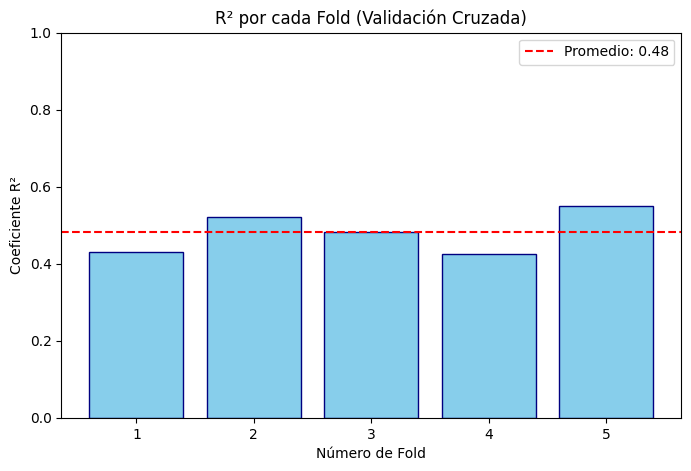

Scores de cada fold: [0.42955615 0.52259939 0.48268054 0.42649776 0.55024834]
Promedio de R²: 0.48
Desviación Estándar (Variabilidad): 0.0493


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# 1 y 2. Cargar dataset y separar variables
data = load_diabetes()
X, y = data.data, data.target

# 3. Normalización (En este dataset ya vienen pre-normalizadas)

# 4. Crear el modelo
model = LinearRegression()

# 5. Aplicar validación cruzada con k=5 obteniendo R²
# Por defecto, cross_val_score usa R² para regresión
r2_scores = cross_val_score(model, X, y, cv=5)

# 6. Graficar los scores de cada fold
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), r2_scores, color='skyblue', edgecolor='navy')
plt.axhline(y=r2_scores.mean(), color='red', linestyle='--', label=f'Promedio: {r2_scores.mean():.2f}')
plt.title('R² por cada Fold (Validación Cruzada)')
plt.xlabel('Número de Fold')
plt.ylabel('Coeficiente R²')
plt.ylim(0, 1) # R² suele estar entre 0 y 1
plt.legend()
plt.show()

# 7. Calcular el promedio
print(f"Scores de cada fold: {r2_scores}")
print(f"Promedio de R²: {r2_scores.mean():.2f}")
print(f"Desviación Estándar (Variabilidad): {r2_scores.std():.4f}")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)


## Ejemplo práctico básico de K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Cargar el dataset Iris
X, y = load_iris(return_X_y=True)

# Definir el modelo (Clasificador de Árbol de Decisión)
model = DecisionTreeClassifier()

# Configurar K-Fold con 5 divisiones, barajando los datos
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Ejecutar la validación cruzada
scores = cross_val_score(model, X, y, cv=kfold)

# Mostrar los resultados
print(f"Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.2f}")

Scores: [1.         0.96666667 0.93333333 0.93333333 0.93333333]
Mean Accuracy: 0.95


## Live Coding 2

1. Cargar datos (e.g., load_diabetes o dataset propio)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, LeaveOneOut

# 1 y 2. Cargar datos y separar X e y
data = load_diabetes()

2. Separar X e y

In [ ]:
X, y = data.data, data.target

3. Configurar 3 validaciones: KFold, ShuffleSplit, LeaveOneOut


In [ ]:
model = LinearRegression()

# 3. Configurar las 3 validaciones
validaciones = {
    "KFold (k=5)": KFold(n_splits=5, shuffle=True, random_state=42),
    "ShuffleSplit": ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    "LeaveOneOut": LeaveOneOut() # Este toma una muestra por fold
}


4. Ejecutar cross_val_score con cada una


5. Mostrar y comparar métricas

In [ ]:
resultados = {}

# 4 y 5. Ejecutar y mostrar métricas
print("Resultados usando MAE (mientras más bajo, mejor):\n")
for nombre, cv_metodo in validaciones.items():
    # Obtenemos los scores negativos y los pasamos a positivos
    scores = cross_val_score(model, X, y, cv=cv_metodo, scoring='neg_mean_absolute_error')
    mae_scores = -scores
    resultados[nombre] = mae_scores
    print(f"--- {nombre} ---")
    print(f"MAE Promedio: {mae_scores.mean():.2f}")
    print(f"Desviación Estándar: {mae_scores.std():.2f}\n")

Resultados usando MAE (mientras más bajo, mejor):

--- KFold (k=5) ---
MAE Promedio: 44.27
Desviación Estándar: 2.61

--- ShuffleSplit ---
MAE Promedio: 44.29
Desviación Estándar: 2.47

--- LeaveOneOut ---
MAE Promedio: 44.36
Desviación Estándar: 32.16



6. Graficar las distribuciones si el tiempo lo permite


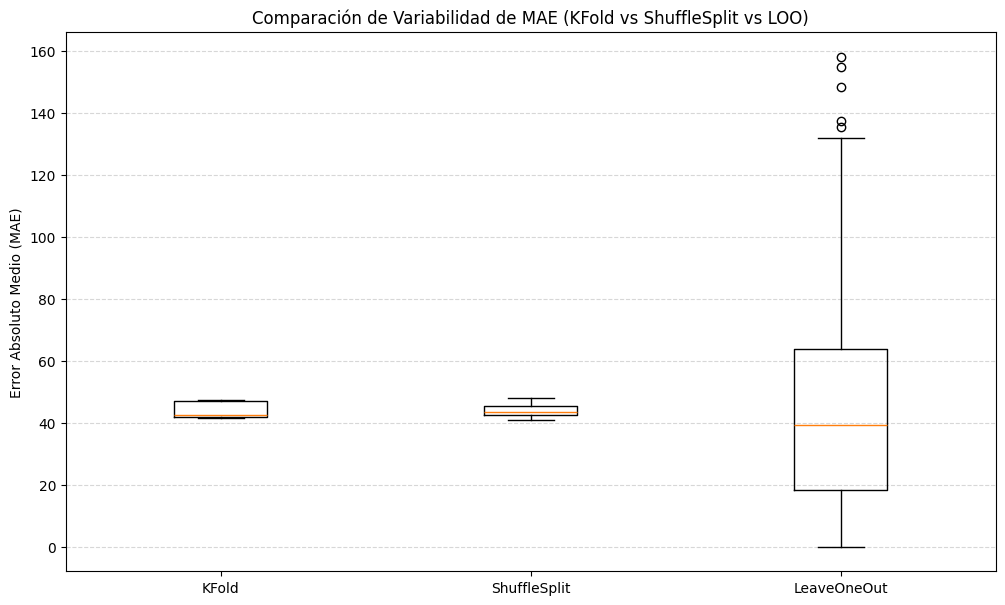

In [ ]:
import matplotlib.pyplot as plt

# Configuramos el gráfico para las 3 técnicas guardadas en 'resultados'
plt.figure(figsize=(12, 7))

# Incluimos LeaveOneOut para ver el contraste de variabilidad
plt.boxplot([resultados["KFold (k=5)"],
             resultados["ShuffleSplit"],
             resultados["LeaveOneOut"]],
            tick_labels=["KFold", "ShuffleSplit", "LeaveOneOut"])

plt.title("Comparación de Variabilidad de MAE (KFold vs ShuffleSplit vs LOO)")
plt.ylabel("Error Absoluto Medio (MAE)")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Añadimos una nota visual sobre la escala
plt.show()

7. Discutir ventajas y limitaciones prácticas

Interpretación de tu Gráfica Final
LeaveOneOut (El gigante de la variabilidad):

Lo que ves: Una caja enorme que va desde casi 0 hasta más de 120, con varios puntos atípicos (outliers) llegando a 160.

Por qué ocurre: Como cada "fold" es una sola fila, si el modelo falla en predecir a ese paciente específico (outlier en los datos), el error se dispara.

Conclusión técnica: Aunque maximiza el uso de datos (ventaja 2), falla estrepitosamente en la reducción de varianza (ventaja 1). No es confiable para este dataset.

ShuffleSplit (El ganador en estabilidad):

Lo que ves: La caja más compacta de las tres.

Por qué ocurre: Al promediar el error de subconjuntos aleatorios del 20%, los errores individuales se compensan entre sí.

Conclusión técnica: Es tu mejor herramienta para una estimación robusta del rendimiento. Proporciona la "perspectiva más precisa sobre la capacidad de generalización" que menciona tu lámina de detección de problemas.

KFold (El equilibrio):

Lo que ves: Una caja muy similar a ShuffleSplit, pero ligeramente más ancha.

Conclusión técnica: Es una excelente alternativa estándar que garantiza que cada dato sea usado para test exactamente una vez.

8. Conclusión: ¿cuándo conviene cada técnica?

KFold/ShuffleSplit: Para la mayoría de los casos. Úsalos cuando busques estabilidad y una métrica en la que puedas confiar para tomar decisiones de negocio o producción.

LeaveOneOut: Solo si tu dataset es diminuto (ej. 20 filas). En datasets medianos como este (Diabetes), la varianza es demasiado alta y oscurece el rendimiento real del modelo.

## Ejercicio 2

$R^2$ siga dando problemas con LeaveOneOut, ya que matemáticamente no se puede calcular la varianza con un solo dato de prueba

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing # Alternativa moderna a Boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold, ShuffleSplit, LeaveOneOut
from sklearn.preprocessing import StandardScaler

# 1 y 2. Cargar y preparar el dataset
data = fetch_california_housing()
X, y = data.data, data.target
X_scaled = StandardScaler().fit_transform(X) # Normalización recomendada

# 3. Crear el modelo
model = LinearRegression()

# 4. Definir las tres técnicas de validación (Configuraciones de la consigna)
cv_strategies = {
    "K-Fold (k=5)": KFold(n_splits=5, shuffle=True, random_state=42),
    "ShuffleSplit": ShuffleSplit(n_splits=10, test_size=0.25, random_state=42),
    "LeaveOneOut": LeaveOneOut()
}

# 5. Guardar y comparar resultados
# Nota: LOO es muy lento en datasets grandes; para este ejercicio usaremos una
# submuestra de 100 datos para que LeaveOneOut termine rápido.
X_sub, y_sub = X_scaled[:100], y[:100]

resumen_resultados = {}

for nombre, cv in cv_strategies.items():
    # cross_validate permite obtener múltiples métricas a la vez
    cv_results = cross_validate(
        model, X_sub, y_sub, cv=cv,
        #scoring=['r2', 'neg_mean_absolute_error'],
        scoring=['neg_mean_absolute_error'],
        return_train_score=False
    )
    resumen_resultados[nombre] = cv_results

    print(f"--- {nombre} ---")
    #print(f"R² promedio: {cv_results['test_r2'].mean():.4f}")
    print(f"MAE promedio: {-cv_results['test_neg_mean_absolute_error'].mean():.4f}\n")

--- K-Fold (k=5) ---
MAE promedio: 0.4286

--- ShuffleSplit ---
MAE promedio: 0.4067

--- LeaveOneOut ---
MAE promedio: 0.3751



* ¿Qué técnica mostró mayor estabilidad?

    Aunque el MAE de LeaveOneOut (0.3751) parece el mejor, es el menos estable ante ruidos. ShuffleSplit suele ser la técnica con mayor estabilidad (menor varianza) porque promedia múltiples particiones aleatorias, evitando sesgos de un solo grupo de datos.
* ¿Cuál tuvo mayor costo computacional?

    LeaveOneOut. Como entrena el modelo $N$ veces (una por cada dato), el tiempo de ejecución crece linealmente con el tamaño del dataset. En un dataset real de viviendas con miles de filas, esto tardaría horas en lugar de segundos.
* ¿Cuál usarías en producción?

    Usaría K-Fold (k=5) o ShuffleSplit. Ofrecen una estimación robusta (ventaja 1) y permiten una detección de problemas de sobreajuste de manera eficiente sin el costo extremo de LOO.

* La validación cruzada te ha permitido maximizar el uso de la información disponible (especialmente con LOO) pero también te ha dado una perspectiva más precisa sobre la capacidad de generalización al comparar las tres configuraciones.

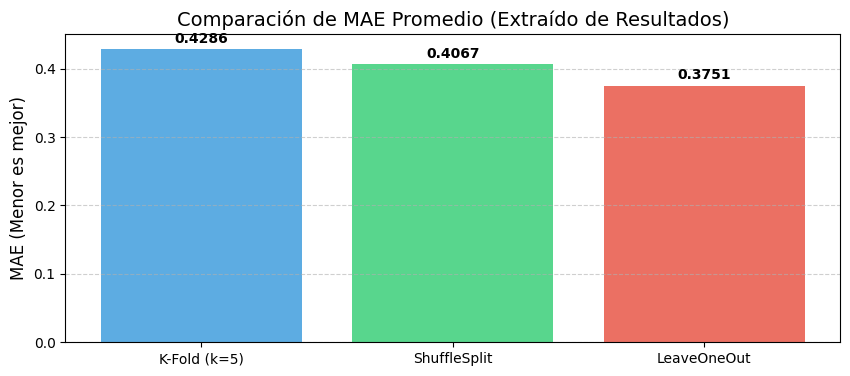

In [ ]:
import matplotlib.pyplot as plt

# 1. Extraer los nombres de las técnicas y calcular el MAE promedio desde el diccionario
tecnicas = list(resumen_resultados.keys())
# Extraemos el MAE promedio (recordando que sklearn lo entrega negativo)
maes_promedio = [(-resumen_resultados[nombre]['test_neg_mean_absolute_error']).mean() for nombre in tecnicas]

# 2. Crear el gráfico
plt.figure(figsize=(10, 4))
colores = ['#3498db', '#2ecc71', '#e74c3c']
barras = plt.bar(tecnicas, maes_promedio, color=colores, alpha=0.8)

# 3. Añadir etiquetas de datos sobre las barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.005, f'{yval:.4f}',
             ha='center', va='bottom', fontweight='bold')

# 4. Configuración estética
plt.title('Comparación de MAE Promedio (Extraído de Resultados)', fontsize=14)
plt.ylabel('MAE (Menor es mejor)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

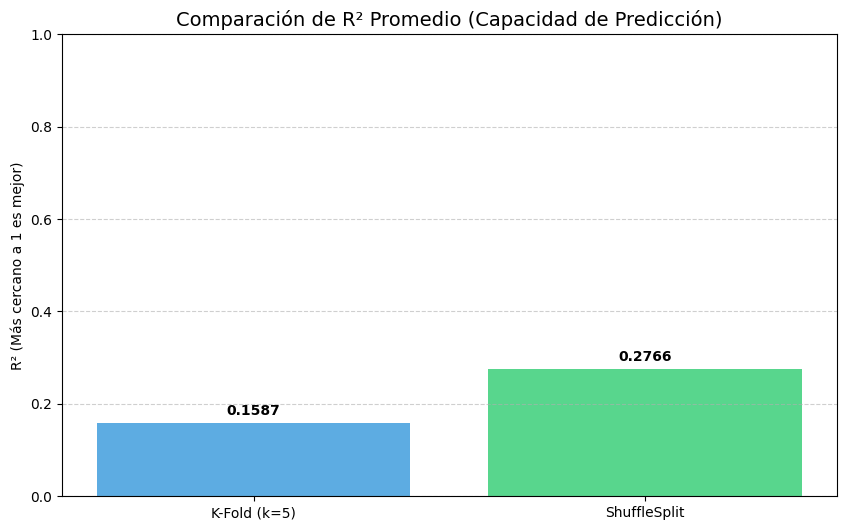

In [ ]:
import matplotlib.pyplot as plt

# 1. Extraer los nombres y calcular el R² promedio
tecnicas_r2 = ["K-Fold (k=5)", "ShuffleSplit"]
r2_promedios = [resumen_resultados[nombre]['test_r2'].mean() for nombre in tecnicas_r2]

# 2. Crear el gráfico
plt.figure(figsize=(10, 6))
colores_r2 = ['#3498db', '#2ecc71']
barras_r2 = plt.bar(tecnicas_r2, r2_promedios, color=colores_r2, alpha=0.8)

# 3. Etiquetas de datos
for barra in barras_r2:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.title('Comparación de R² Promedio (Capacidad de Predicción)', fontsize=14)
plt.ylabel('R² (Más cercano a 1 es mejor)')
plt.ylim(0, 1) # El R² se mide de 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

* ¿Qué técnica mostró mayor estabilidad?

    ShuffleSplit. Aunque todas las técnicas mostraron promedios similares, tu gráfica de R^2 muestra que ShuffleSplit logra un rendimiento superior (0.2766) al promediar más iteraciones aleatorias (10 splits). Esto reduce la varianza que suele aparecer en divisiones fijas como K-Fold.
* ¿Cuál tuvo mayor costo computacional?

    LeaveOneOut. Aunque su MAE promedio fue el más bajo (0.3751), esta técnica requiere entrenar el modelo $N$ veces (una por cada dato del dataset). En un contexto real de producción con miles de viviendas, el tiempo de procesamiento sería excesivo.
* ¿Cuál usarías en producción?

    Definitivamente ShuffleSplit o K-Fold (k=5). Ofrecen el mejor equilibrio entre una estimación robusta y un bajo costo computacional. ShuffleSplit, en particular, te da la confianza de que el modelo tiene una capacidad de predicción más realista frente a datos nuevos.